# Fake News

## Import

In [1]:
import re
import time

import nltk
import pandas as pd
from matplotlib import pyplot as plt
from nltk import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from wordcloud import WordCloud

nltk.download('punkt')  # for tokenization
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\marco\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marco\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Load Dataset

In [2]:
df = pd.read_csv('../american_datasets/cleaned/4.csv', index_col=0)
df.head()

title  \
0  muslims busted they stole millions in govt ben...   
1  re why did attorney general loretta lynch plea...   
2  breaking weiner cooperating with fbi on hillar...   
3  pin drop speech by father of daughter kidnappe...   
4  fantastic trumps  point plan to reform healthc...   

                                                text label  
0  print they should pay all the back all the mon...  True  
1  why did attorney general loretta lynch plead t...  True  
2  red state  \nfox news sunday reported this mor...  True  
3  email kayla mueller was a prisoner and torture...  True  
4  email healthcare reform to make america great ...  True

In [3]:
df.shape

(2096, 3)

## Visualization

(array([ 801.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1295.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

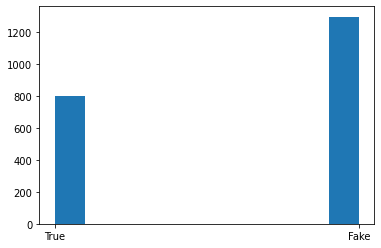

In [4]:
plt.hist(df['label'])

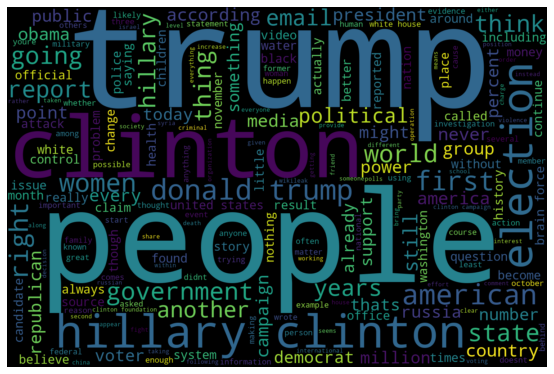

In [5]:
all_text = " ".join([str(txt) for txt in df[df['label'] == 'Fake']['text']])

wordcloud = WordCloud(min_word_length=5, width=1500, height=1000, background_color='black').generate(all_text)

fig = plt.figure(figsize=(20, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Preprocessing

### Remove junk

In [6]:
def clean(text):
    text = str(text)
    #all lowercase
    text = text.lower()

    # remove escape sequences
    text = re.sub(r'(\r\n|\n|\r|\t)', ' ', text)

    # remove urls
    text = re.sub(
        r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)', ' ',
        text)

    # remove html
    text = re.sub(r'<.*?>', ' ', text)

    # remove emoj
    text = re.sub(r"["u"\U0001F600-\U0001F64F"  # emoticons
                  u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                  u"\U0001F680-\U0001F6FF"  # transport & map symbols
                  u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                  u"\U00002702-\U000027B0"
                  u"\U000024C2-\U0001F251"
                  "]+", " ", text, flags=re.UNICODE)

    # remove all not alphanumeric character
    text = re.sub("[^a-z]+", " ", text)
    return text


df['title'] = [clean(title) for title in df['title']]
df['text'] = [clean(text) for text in df['text']]
df.head()

title  \
0  muslims busted they stole millions in govt ben...   
1  re why did attorney general loretta lynch plea...   
2  breaking weiner cooperating with fbi on hillar...   
3  pin drop speech by father of daughter kidnappe...   
4  fantastic trumps point plan to reform healthca...   

                                                text label  
0  print they should pay all the back all the mon...  True  
1  why did attorney general loretta lynch plead t...  True  
2  red state fox news sunday reported this mornin...  True  
3  email kayla mueller was a prisoner and torture...  True  
4  email healthcare reform to make america great ...  True

### Remove stop words

In [7]:
stop_words = set(stopwords.words("english"))


def remove_stop_words(text):
    res = []
    for word in text.split():
        if word not in stop_words:
            res.append(word)
    return " ".join(res)


df['title'] = [remove_stop_words(title) for title in df['title']]
df['text'] = [remove_stop_words(text) for text in df['text']]
df.head()

title  \
0        muslims busted stole millions govt benefits   
1         attorney general loretta lynch plead fifth   
2  breaking weiner cooperating fbi hillary email ...   
3  pin drop speech father daughter kidnapped kill...   
4  fantastic trumps point plan reform healthcare ...   

                                                text label  
0  print pay back money plus interest entire fami...  True  
1  attorney general loretta lynch plead fifth bar...  True  
2  red state fox news sunday reported morning ant...  True  
3  email kayla mueller prisoner tortured isis cha...  True  
4  email healthcare reform make america great sin...  True

### Stemming

In [8]:
snowball_stemmer = SnowballStemmer(language='english')


def stemmer(text):
    res = []
    for word in text.split():
        res.append(snowball_stemmer.stem(word))
    return " ".join(res)


df['title'] = [stemmer(title) for title in df['title']]
df['text'] = [stemmer(text) for text in df['text']]
df.head()

title  \
0             muslim bust stole million govt benefit   
1         attorney general loretta lynch plead fifth   
2     break weiner cooper fbi hillari email investig   
3  pin drop speech father daughter kidnap kill is...   
4  fantast trump point plan reform healthcar begi...   

                                                text label  
0  print pay back money plus interest entir famil...  True  
1  attorney general loretta lynch plead fifth bar...  True  
2  red state fox news sunday report morn anthoni ...  True  
3  email kayla mueller prison tortur isi chanc re...  True  
4  email healthcar reform make america great sinc...  True

## ML Model

In [9]:
def print_metrics(y_test, y_pred, training_time):
    print('0. Training time:', round(training_time), 's')
    print('1. Accuracy:', round(accuracy_score(y_test, y_pred), 4))
    print('2. Precision:', round(precision_score(y_test, y_pred, average='macro'), 4))
    print('3. Recall:', round(recall_score(y_test, y_pred, average='macro'), 4))
    print('4. F1 score:', round(f1_score(y_test, y_pred, average='macro'), 4))
    print('5. Confusion Matrix\n\n', pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted']))

In [10]:
X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [11]:
# pre processing
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
countVectorizer = CountVectorizer(min_df=2, max_df=0.7, ngram_range=(1, 2), tokenizer=token.tokenize)
tfidfTransformer = TfidfTransformer()

classifiers = [
    RandomForestClassifier(n_jobs=8),
    LogisticRegression(n_jobs=8),
    DecisionTreeClassifier(),
    AdaBoostClassifier(),
    KNeighborsClassifier(n_jobs=8)
]

#fit and prediction
for classifier in classifiers:
    start_time = time.time()
    
    print('---------------------------------')
    print(str(classifier))
    pipe = Pipeline(
        [
            ('vect', countVectorizer),
            ('tfidf', tfidfTransformer),
            ('classifier', classifier)
        ]
    )

    model = pipe.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    training_time = time.time() - start_time 
    print_metrics(y_test, y_pred, training_time)

---------------------------------
RandomForestClassifier(n_jobs=8)


0. Training time: 1 s
1. Accuracy: 0.7599
2. Precision: 0.7495
3. Recall: 0.7029
4. F1 score: 0.714
5. Confusion Matrix

 Predicted  Fake  True
Actual               
Fake        365    42
True        109   113
---------------------------------
LogisticRegression(n_jobs=8)


0. Training time: 1 s
1. Accuracy: 0.7536
2. Precision: 0.7943
3. Recall: 0.6652
4. F1 score: 0.6732
5. Confusion Matrix

 Predicted  Fake  True
Actual               
Fake        393    14
True        141    81
---------------------------------
DecisionTreeClassifier()


0. Training time: 2 s
1. Accuracy: 0.717
2. Precision: 0.698
3. Recall: 0.7107
4. F1 score: 0.7011
5. Confusion Matrix

 Predicted  Fake  True
Actual               
Fake        298   109
True         69   153
---------------------------------
AdaBoostClassifier()


0. Training time: 2 s
1. Accuracy: 0.752
2. Precision: 0.7285
3. Recall: 0.7193
4. F1 score: 0.7232
5. Confusion Matrix

 Predicted  Fake  True
Actual               
Fake        338    69
True         87   135
---------------------------------
KNeighborsClassifier(n_jobs=8)


0. Training time: 1 s
1. Accuracy: 0.6773
2. Precision: 0.6747
3. Recall: 0.6912
4. F1 score: 0.6692
5. Confusion Matrix

 Predicted  Fake  True
Actual               
Fake        262   145
True         58   164
